In [12]:
import os
import sys
import argparse

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from aiida.backends.utils import load_dbenv, is_dbenv_loaded
if not is_dbenv_loaded():
    load_dbenv()

from aiida.orm import CalculationFactory, DataFactory
from aiida.orm.code import Code
from aiida.orm.data.base import Int, Float, Str
from aiida.orm.data.upf import UpfData
from aiida.orm.data.structure import StructureData
from aiida.common.exceptions import NotExistent
from aiida.work.run import run, async, submit
from aiida.work.workchain import WorkChain, ToContext, while_, Outputs

from common.structure.generate import create_diamond_fcc, scale_structure
from common.pseudo.qe import get_pseudos

KpointsData = DataFactory("array.kpoints")
ParameterData = DataFactory('parameter')
PwCalculation = CalculationFactory('quantumespresso.pw')

%matplotlib notebook
import matplotlib.pyplot as plt

In [16]:
class EquationOfState(WorkChain):
    """
    Workchain that for a given structure will compute the equation of state by
    computing the total energy for a set of derived structures with a scaled
    lattice parameter
    """

    @classmethod
    def define(cls, spec):
        super(EquationOfState, cls).define(spec)
        spec.input("structure", valid_type=StructureData)
        spec.input("codename", valid_type=Str)
        spec.input("pseudo_family", valid_type=Str)
        spec.input("npoints", valid_type=Int)
        spec.outline(
            cls.init,
            while_(cls.should_run_pw)(
                cls.run_pw,
                cls.parse_pw,
            ),
            cls.return_result,
        )
        spec.dynamic_output()

    def init(self):
        """
        Initialize variables and the scales we want to compute
        """
        kpoints = KpointsData()
        kpoints.set_kpoints_mesh([2, 2, 2])

        npoints = self.inputs.npoints.value
        self.ctx.i = 0
        self.ctx.scales = sorted([1 - pow(-1, x)*0.02*int((x+1)/2) for x in range(npoints)])
        self.ctx.result = []
        self.ctx.options = {
            "resources": {
                "num_machines": 1,
                "tot_num_mpiprocs": 1,
            },
            "max_wallclock_seconds": 30 * 60,
        }
        self.ctx.parameters = {
            "CONTROL": {
                "calculation": "scf",
                "tstress": True,
                "tprnfor": True,
            },
            "SYSTEM": {
                "ecutwfc": 30.,
                "ecutrho": 200.,
            },
            "ELECTRONS": {
                "conv_thr": 1.e-6,
            }
        }
        self.ctx.kpoints = kpoints
        self.ctx.pseudos = get_pseudos(self.inputs.structure, self.inputs.pseudo_family.value)
        
        # Initialize plot variables
        self.fig, self.ax = plt.subplots(1,1)
        self.ax.set_xlabel(u"Volume [Å^3]")
        self.ax.set_ylabel(u"Total energy [eV]")

    def should_run_pw(self):
        """
        Determine whether a calculation should still be run
        """
        return self.ctx.i < len(self.ctx.scales)

    def run_pw(self):
        """
        Run a PwCalculation for the current scaling factor
        """
        scale = self.ctx.scales[self.ctx.i]
        structure = scale_structure(self.inputs.structure, Float(scale))
        self.ctx.i += 1

        # Create the input dictionary
        inputs = {
            'code'       : Code.get_from_string(self.inputs.codename.value),
            'pseudo'     : self.ctx.pseudos,
            'kpoints'    : self.ctx.kpoints,
            'structure'  : structure,
            'parameters' : ParameterData(dict=self.ctx.parameters),
            '_options'   : self.ctx.options,
        }

        # Create the calculation process and launch it
        self.report("Running pw.x for the scale factor {}".format(scale))
        process = PwCalculation.process()
        future  = async(process, **inputs)

        return ToContext(pw=Outputs(future))

    def parse_pw(self):
        """
        Extract the volume and total energy of the last completed PwCalculation
        """
        volume = self.ctx.pw["output_parameters"].dict.volume
        energy = self.ctx.pw["output_parameters"].dict.energy
        self.ctx.result.append((volume, energy))
        
        self.plot_data()

        return

    def return_result(self):
        """
        Attach the results of the PwCalculations and the initial structure to the outputs
        """
        result = {
            "initial_structure": self.inputs.structure,
            "result": ParameterData(dict={"eos": self.ctx.result}),
        }

        for link_name, node in result.iteritems():
            self.out(link_name, node)

        self.report("Workchain <{}> completed successfully".format(self.calc.pk))

        return

    def plot_data(self):
        self.ax.plot(*zip(*self.ctx.result), marker='o', linestyle='--', color='r')
        self.fig.canvas.draw()

In [14]:
def execute(args):
    """
    The main execution of the script, which will run some preliminary checks on the command
    line arguments before passing them to the workchain and running it
    """
    try:
        code = Code.get_from_string(args.codename)
    except NotExistent as exception:
        print "Execution failed: could not retrieve the code '{}'".format(args.codename)
        print "Exception report: {}".format(exception)
        return

    try:
        pseudo_family = UpfData.get_upf_group(args.pseudo_family)
    except NotExistent as exception:
        print "Execution failed: could not retrieve the pseudo family '{}'".format(args.pseudo_family)
        print "Exception report: {}".format(exception)
        return

    try:
        structure = create_diamond_fcc(Str(args.element), Float(args.alat))
    except Exception as exception:
        print "Execution failed: failed to construct a structure for the given element '{}'".format(args.element)
        print "Exception report: {}".format(exception)
        return

    outputs = run(
        EquationOfState,
        npoints=Int(args.npoints),
        structure=structure,
        codename=Str(args.codename),
        pseudo_family=Str(args.pseudo_family)
    )

    return outputs["result"]

<IPython.core.display.Javascript object>


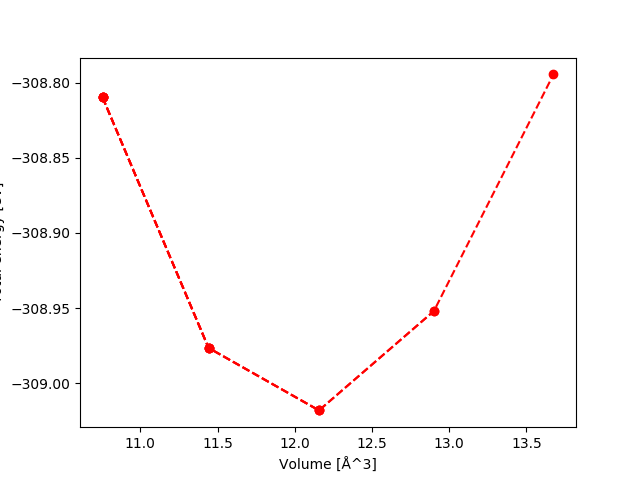

04/13/2017 11:35:47 AM, aiida.orm.implementation.general.calculation.work.WorkCalculation: [REPORT] Running pw.x for the scale factor 0.96
04/13/2017 11:35:53 AM, aiida.orm.implementation.general.calculation.work.WorkCalculation: [REPORT] Running pw.x for the scale factor 0.98
04/13/2017 11:36:03 AM, aiida.orm.implementation.general.calculation.work.WorkCalculation: [REPORT] Running pw.x for the scale factor 1.0
04/13/2017 11:36:13 AM, aiida.orm.implementation.general.calculation.work.WorkCalculation: [REPORT] Running pw.x for the scale factor 1.02
04/13/2017 11:36:23 AM, aiida.orm.implementation.general.calculation.work.WorkCalculation: [REPORT] Running pw.x for the scale factor 1.04
04/13/2017 11:36:34 AM, aiida.orm.implementation.general.calculation.work.WorkCalculation: [REPORT] Workchain <4433> completed successfully



Final results of the equation of state workchain:

Volume (A^3)  Energy (eV) 
--------------------------
    10.75554    -308.80986
    11.44187    -308.97652
    12.15678    -309.01809
    12.90087    -308.95200
    13.67473    -308.79458


In [17]:
# Input variables
element='C'
alat=3.65
npoints=5

# Create the starting structure
structure = create_diamond_fcc(Str(element), Float(alat))

# Define the code and pseudo family to be used
codename='pw-v5.4.0@localhost'
pseudo_family='SSSP_v0.7_eff_PBE'

# Run the workchain
outputs = run(
    EquationOfState,
    npoints=Int(npoints),
    structure=structure,
    codename=Str(codename),
    pseudo_family=Str(pseudo_family)
)

print "\nFinal results of the equation of state workchain:\n"
print "{volume:12}  {energy:12}".format(volume="Volume (A^3)", energy="Energy (eV)")
print "{}".format("-"*26)
for p in outputs["result"].get_dict()['eos']:
    print "{volume:>12.5f}  {energy:>12.5f}".format(volume=p[0], energy=p[1])